# AMV from ERA5, HadISST and HighResMIP 

### Load Modules

In [2]:
import numpy as np
import numpy.matlib 
import math
from scipy import signal
import xarray as xr
from scipy.stats import gaussian_kde, ttest_ind, ks_2samp
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.markers import MarkerStyle
import cartopy
import cartopy.crs as ccrs
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta, MO
import datetime
import matplotlib.animation as animation
from matplotlib import rc
from dask.distributed import Client, LocalCluster
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import os
import glob
import gc
import warnings
from tqdm import tqdm

In [3]:
# Set up cluster and workers
cluster = LocalCluster(n_workers=4, threads_per_worker=4)
client = Client(cluster)
client

/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37421 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:37421/status,
Dashboard: http://127.0.0.1:37421/status,Workers: 4
Total threads: 16,Total memory: 235.37 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35701,Workers: 4
Dashboard: http://127.0.0.1:37421/status,Total threads: 16
Started: Just now,Total memory: 235.37 GiB
Comm: tcp://127.0.0.1:42175,Total threads: 4
Dashboard: http://127.0.0.1:42465/status,Memory: 58.84 GiB
Nanny: tcp://127.0.0.1:38379,


### Define functions

In [6]:
def butter_lowpass_filter(data, cutoff_freq=1/11, sample_rate=1, order=4):
    """
    Apply Butterworth Filter 
    
    data - Input data
    cutoff_freq = 1/11 - 11 year filter - the critical frequency or frequencies
    sample_rate = 1 - assuming data is annual 
    order = 4 - The order of the filter
    
    """
    b, a = signal.butter(order, cutoff_freq, btype='low', analog=False)
    y = signal.filtfilt(b, a, data)
    return y

### Load data and calculate AMV Index

In [7]:
### Longitude, Latitude slice for classical NA box -> Fig. 5 ###
lon_slice = slice(285.0, 352.5)
lat_slice = slice(60.0, 0.0)

### Longitude, Latitude slice for NEA box -> Fig. S8 ###
#lon_slice = slice(320.0, 345.0)
#lat_slice = slice(60.0, 45.0)

############################################

# suppress "Mean of empty slice" 
warnings.filterwarnings("ignore", category=RuntimeWarning, message="Mean of empty slice")

# Set model, variables, resolutions
model_name =['ERA5_','HadGEM3-GC31_','CNRM-CM6_','EC-Earth3P_','ECMWF-IFS_','CMCC-CM2_', 'MPI-ESM1-2_','FOCI_']
ERA5_variable = ['sea_surface_temperature']
FOCI_variable = ['tsw']
variable = ['tos_','tas_']
resolution = [[''],
              ['-LL', '-MM', '-HH'],
              ['-1' , '-1-HR'],
              ['', '-HR'],
              ['-LR', '-MR','-HR'],
              ['-HR4','-VHR4'],
              ['-HR', '-XR','-ER','-HR-PP'],
              ['-Standard' ,'-VIKING10']]

HighRes_model_tos_mon = {}       
HighRes_model_tos_mon_anom ={}
HighRes_model_tos_annual={}   
HighRes_model_tos_annual_AMV={}
HighRes_model_tos_AMV={}
HighRes_model_tos_annual_detrend={}
HighRes_model_tos_annual_10yr_rm={}
HighRes_model_tos_annual_AMV_lpf={}
HighRes_model_tos_AMV_lpf={}
HighRes_model_tos_annual_AMV_10yr_rm_detrend={}
HighRes_model_tos_annual_AMV_lpf_detrend={}
HighRes_model_tos_AMV_lpf_detrend={}
for mod in range(len(model_name)):
    HighRes_model={}
    print(model_name[mod])
    ##### Load data sets #####
    for var in range(1):
            for res in range(len(resolution[mod])):
                if mod==0:
                    #Input of ERA5  
                    directory='/work/bm1398/m301111/Reanalysis/ERA5/daily/ERA5__'; file_end= '__1979-2019.nc'
                    HighRes_model['ERA5_'+variable[var]]=xr.open_dataset(directory+ERA5_variable[var]+'__1979-2019.nc').var34
                    
                if mod>0 and mod<7:
                    #Input of HighResMIP models
                    directory ='/work/bm1398/m301111/Models/HighResMIP/'+model_name[mod][:-1]+'/'+variable[var][:-1]+'/'+variable[var]+'daily/'+variable[var]+'day_'+model_name[mod][:-1]; #file_end='_control-1950_r1i1p1f1_gn_19500101-20501231_2_5_deg_06_00_shifted_inverted.nc'
                    file=glob.glob(directory+resolution[mod][res]+'_control*.nc')
                    HighRes_model[model_name[mod]+variable[var]+resolution[mod][res]] = xr.open_dataset(file[0]).tos  
                    
                if mod==7:
                    #Input of FOCI
                    period ='1950-2049'
                    path =     '/work/bm1398/m301111/Models/FOCI/FOCI1.10-TM020_preind_no_nest/'+period+'/'
                    path_nest= '/work/bm1398/m301111/Models/FOCI/FOCI1.10-TM026_preind_VIKING10_nest/'+period+'/'
                    if res==0:
                        FOCI_file       = path+'FOCI1.10-TM020_echam6_echam_'+period+'_'+FOCI_variable[var]+'.nc'
                    if res==1:
                        FOCI_file   = path_nest+'FOCI1.10-TM026_echam6_echam_'+period+'_'+FOCI_variable[var]+'.nc'
                    HighRes_model[model_name[mod]+variable[var]+resolution[mod][res]] = xr.open_dataset(FOCI_file).tsw  


    weights = np.cos(np.deg2rad(HighRes_model[model_name[mod]+variable[0]+resolution[mod][0]].lat)) 
    for res in tqdm(range(len(resolution[mod]))):
        # 1. Calc monthly anomalies 
        HighRes_model_tos_mon [model_name[mod]+variable[0]+resolution[mod][res]+'mon'] =  HighRes_model[model_name[mod]+variable[0]+resolution[mod][res]].resample(time='M').mean()
        HighRes_model_tos_mon_anom[model_name[mod]+variable[0]+resolution[mod][res]+'mon_anom'] = HighRes_model_tos_mon [model_name[mod]+variable[0]+resolution[mod][res]+'mon'].groupby('time.month') - HighRes_model_tos_mon [model_name[mod]+variable[0]+resolution[mod][res]+'mon'].groupby('time.month').mean(dim='time')        
        # 2. Calc annual mean
        HighRes_model_tos_annual[model_name[mod]+variable[0]+resolution[mod][res]+'annual'] = HighRes_model_tos_mon_anom[model_name[mod]+variable[0]+resolution[mod][res]+'mon_anom'].groupby('time.year').mean(dim='time').rename({'year': 'time'})
        # 3. Calc weighted NA area average (0-60°N, 7.5 - 75°W)
        HighRes_model_tos_annual_AMV [model_name[mod]+variable[0]+resolution[mod][res]+'AMV'] = HighRes_model_tos_annual[model_name[mod]+variable[0]+resolution[mod][res]+'annual'].sel(lon=lon_slice, lat=lat_slice).weighted(weights).mean('lon', skipna=True).mean('lat', skipna=True)
        HighRes_model_tos_AMV [model_name[mod]+variable[0]+resolution[mod][res]+'AMV'] = HighRes_model_tos_mon_anom[model_name[mod]+variable[0]+resolution[mod][res]+'mon_anom'].sel(lon=lon_slice, lat=lat_slice).weighted(weights).mean('lon', skipna=True).mean('lat', skipna=True)
        # 4. Calc Butterworth Low Pass Filter
        HighRes_model_tos_annual_AMV_lpf [model_name[mod]+variable[0]+resolution[mod][res]+'AMV_lpf'] = xr.DataArray(data=(butter_lowpass_filter(HighRes_model_tos_annual_AMV[model_name[mod]+variable[0]+resolution[mod][res]+'AMV'].squeeze())), dims=["time"], coords=dict(time=HighRes_model_tos_annual_AMV[model_name[mod]+variable[0]+resolution[mod][res]+'AMV'].time))
        HighRes_model_tos_AMV_lpf [model_name[mod]+variable[0]+resolution[mod][res]+'AMV_lpf'] = xr.DataArray(data=(butter_lowpass_filter(HighRes_model_tos_AMV[model_name[mod]+variable[0]+resolution[mod][res]+'AMV'].squeeze())), dims=["time"], coords=dict(time=HighRes_model_tos_AMV[model_name[mod]+variable[0]+resolution[mod][res]+'AMV'].time))
        # 5. Detrend SST data and remove long term mean
        HighRes_model_tos_annual_AMV_lpf_detrend[model_name[mod]+variable[0]+resolution[mod][res]+'AMV_lpf_detrend'] = xr.DataArray(data=(signal.detrend(HighRes_model_tos_annual_AMV_lpf [model_name[mod]+variable[0]+resolution[mod][res]+'AMV_lpf'], axis=0)), dims=["time"], coords=dict(time=HighRes_model_tos_annual_AMV [model_name[mod]+variable[0]+resolution[mod][res]+'AMV'].time))
        HighRes_model_tos_AMV_lpf_detrend[model_name[mod]+variable[0]+resolution[mod][res]+'AMV_lpf_detrend'] = xr.DataArray(data=(signal.detrend(HighRes_model_tos_AMV_lpf [model_name[mod]+variable[0]+resolution[mod][res]+'AMV_lpf'], axis=0)), dims=["time"], coords=dict(time=HighRes_model_tos_AMV [model_name[mod]+variable[0]+resolution[mod][res]+'AMV'].time))

ERA5_


100%|██████████| 1/1 [00:01<00:00,  1.57s/it]


HadGEM3-GC31_


100%|██████████| 3/3 [04:58<00:00, 99.63s/it] 


CNRM-CM6_


100%|██████████| 2/2 [00:19<00:00,  9.58s/it]


EC-Earth3P_


100%|██████████| 2/2 [02:49<00:00, 84.78s/it]


ECMWF-IFS_


100%|██████████| 3/3 [04:19<00:00, 86.55s/it]


CMCC-CM2_


100%|██████████| 2/2 [12:06<00:00, 363.29s/it]


MPI-ESM1-2_


100%|██████████| 4/4 [00:45<00:00, 11.47s/it]


FOCI_


100%|██████████| 2/2 [00:17<00:00,  8.92s/it]


### Restore variables

In [8]:
%store -r CMIP6_model_Euro_line
%store  -r CMIP6_model_Euro_line_wtm
%store  -r HadISST_NAav_lpf_de
%store  -r HadISST_NEAav_lpf_de
%store  -r HadISST_mon_NAav_lpf_de

In [10]:
# Slice only the time period from 1979 to 2019 in order to be consistent with the ERA5 period
HadISST_AMV_NAav_1979_2019= HadISST_NAav_lpf_de.sel(year=slice(1979,2019))
HadISST_AMV_NEAav_1979_2019= HadISST_NEAav_lpf_de.sel(year=slice(1979,2019))

# Rename time coordinate
#HadISST_mon_NAav_lpf_de_renamed = HadISST_mon_NAav_lpf_de.rename({'year': 'time'})
# Select summer season values
#HadISST_1979_2019_mon_JJA= HadISST_mon_NAav_lpf_de_renamed.where(HadISST_mon_NAav_lpf_de_renamed['time'].dt.month.isin([6, 7, 8]), drop=True).sel(time=slice('1979-01-01','2020-01-01'))

In [11]:
# Modify colormap 
YlOrBr = plt.cm.get_cmap('YlOrBr', 256)
YlOrBr_white = YlOrBr(np.linspace(0, 1, 256))
white = np.array([1., 1., 1., 1.])
YlOrBr_white[0, :] = white
YlOrBr_white_cm= ListedColormap(YlOrBr_white)

### Classify AMV indices into Low and High Res  

In [17]:
low_res_type = [[1,0], # HadGEM
                [2,0], # CNRM
                [3,0], # EC-Earth
                [4,0], # ECMWF   
                [6,0], # MPI-ESM
                [6,1], # MPI-ESM 
                [6,3], # MPI-ESM                
                [7,0]] # FOCI

high_res_type = [[1,1], # HadGEM
                 [1,2], # HadGEM
                 [2,1], # CNRM                 
                 [3,1], # EC-Earth
                 [4,1], # ECMWF 
                 [4,2], # ECMWF   
                 [5,0], # CMCC
                 [5,1], # CMCC 
                 [6,2], # MPI-ESM
                 [7,1]] # FOCI

#### Select low and high res, but still retain model dim for Scatter plot 
LR_AMV = {}
#LR_AMV_mon= {}
LR_AMV_c_sel=[]
HR_AMV = {}
#HR_AMV_mon = {}
HR_AMV_c_sel=[]
LR_T2m={}
HR_T2m = {}

for mod,res in low_res_type:
    LR_AMV[model_name [mod]+ resolution[mod][res]] = HighRes_model_tos_annual_AMV_lpf_detrend[model_name [mod]+ variable[0]+ resolution[mod][res]+'AMV_lpf_detrend']
    LR_T2m[model_name [mod]+ resolution[mod][res]] = CMIP6_model_Euro_line_wtm[model_name[mod]+variable[1]+resolution[mod][res]+'Euro_line_wtm'][0].sel(lead_lag=5)  
    LR_AMV_c_sel.append(LR_AMV[model_name [mod]+ resolution[mod][res]].sel(time = LR_T2m[model_name [mod]+ resolution[mod][res]].time.dt.year.astype(int)))
    #LR_AMV_mon [model_name [mod]+ resolution[mod][res]] =  HighRes_model_tos_AMV_lpf_detrend[model_name[mod]+variable[0]+resolution[mod][res]+'AMV_lpf_detrend'].where(HighRes_model_tos_AMV_lpf_detrend[model_name[mod]+variable[0]+resolution[mod][res]+'AMV_lpf_detrend']['time'].dt.month.isin([6, 7, 8]), drop=True)

for mod,res in high_res_type:
    HR_AMV[model_name [mod]+ resolution[mod][res]] = HighRes_model_tos_annual_AMV_lpf_detrend[model_name [mod]+ variable[0]+ resolution[mod][res]+'AMV_lpf_detrend']
    HR_T2m[model_name [mod]+ resolution[mod][res]] = CMIP6_model_Euro_line_wtm[model_name[mod]+variable[1]+resolution[mod][res]+'Euro_line_wtm'][0].sel(lead_lag=5) 
    HR_AMV_c_sel.append(HR_AMV[model_name [mod]+ resolution[mod][res]].sel(time = HR_T2m[model_name [mod]+ resolution[mod][res]].time.dt.year.astype(int)))
    #HR_AMV_mon [model_name [mod]+ resolution[mod][res]] =  HighRes_model_tos_AMV_lpf_detrend[model_name[mod]+variable[0]+resolution[mod][res]+'AMV_lpf_detrend'].where(HighRes_model_tos_AMV_lpf_detrend[model_name[mod]+variable[0]+resolution[mod][res]+'AMV_lpf_detrend']['time'].dt.month.isin([6, 7, 8]), drop=True)

LR_AMV_c_sel_concat = xr.concat(LR_AMV_c_sel, dim='time')
LR_T2m_concat = xr.concat(LR_T2m.values(), dim='time')
HR_AMV_c_sel_concat = xr.concat(HR_AMV_c_sel, dim='time')
HR_T2m_concat = xr.concat(HR_T2m.values(), dim='time')
#LR_AMV_mon_concat = xr.concat(LR_AMV_mon.values(), dim='time')
#HR_AMV_mon_concat = xr.concat(HR_AMV_mon.values(), dim='time')

### Scatter plots

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


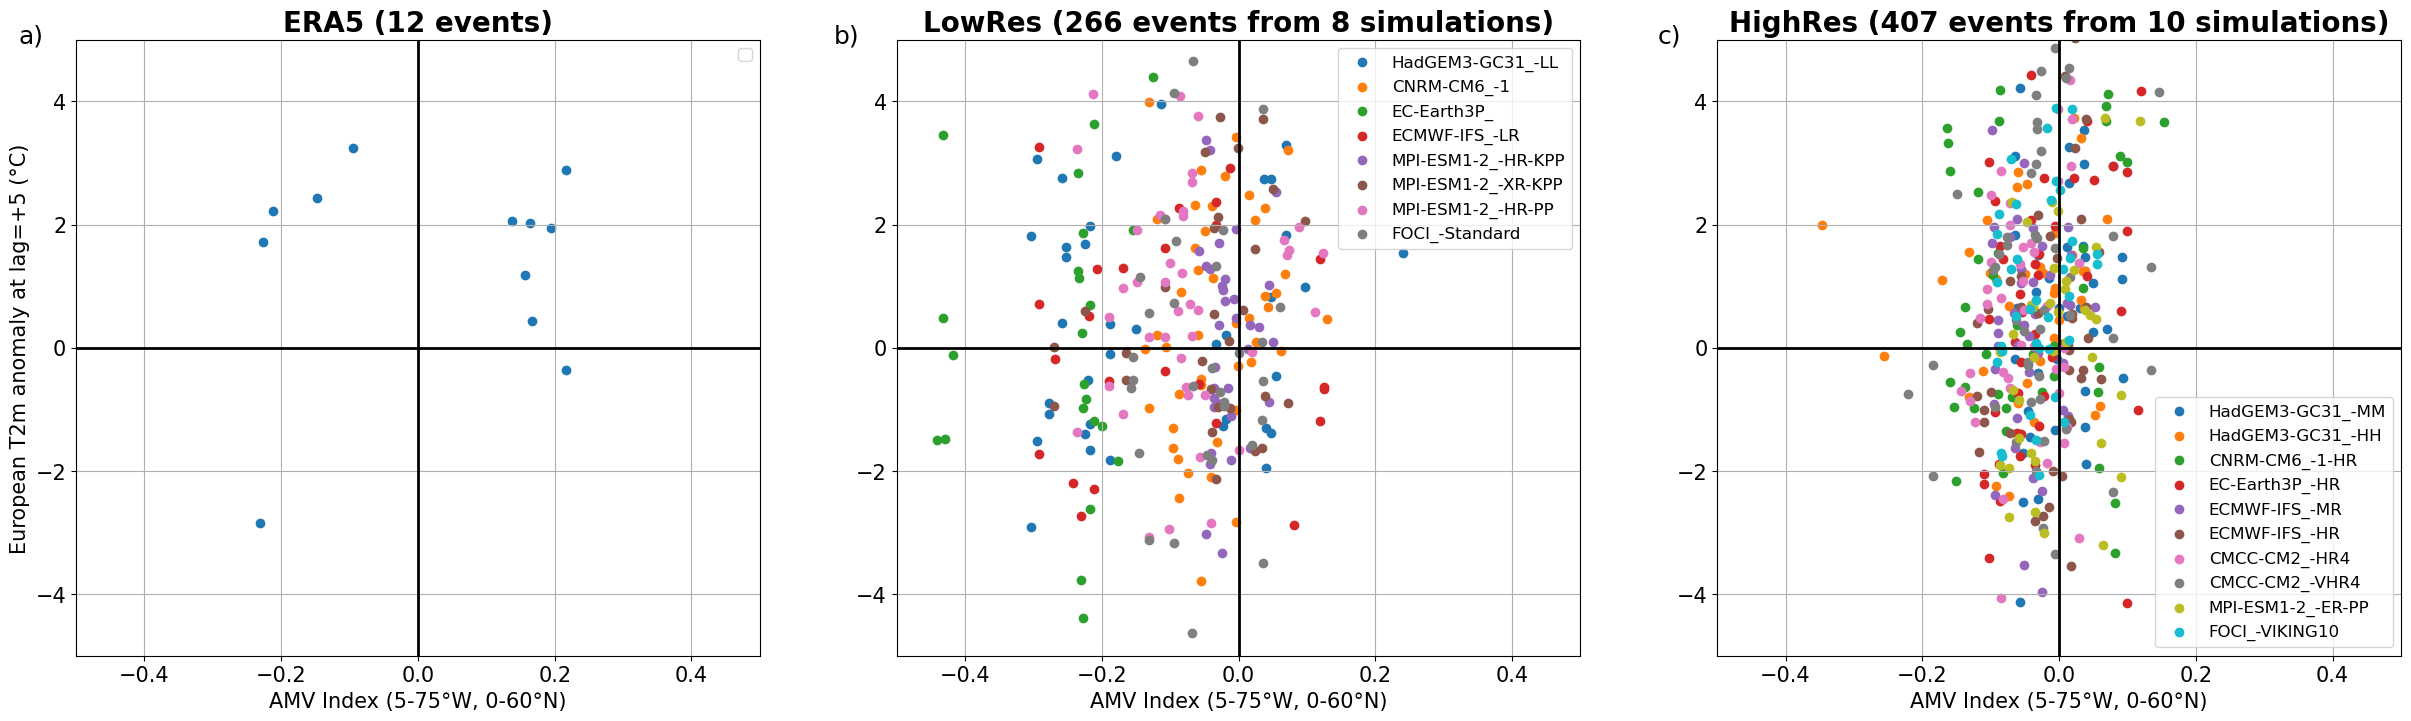

In [18]:
resolution_upd = [[''],
              ['-LL', '-MM', '-HH'],
              ['-1' , '-1-HR'],
              ['', '-HR'],
              ['-LR', '-MR','-HR'],
              ['-HR4','-VHR4'],
              ['-HR-KPP', '-XR-KPP','-ER-PP','-HR-PP'],
              ['-Standard' ,'-VIKING10']]

plt.rcParams['font.size'] = '15'


A = [HadISST_AMV_NAav_1979_2019, LR_AMV, HR_AMV]
B = [CMIP6_model_Euro_line_wtm[model_name[0]+variable[1]+resolution[0][0]+'Euro_line_wtm'][0].sel(lead_lag=5), LR_T2m, HR_T2m]


titles=['ERA5 (12 events)','LowRes (266 events from 8 simulations)', 'HighRes (407 events from 10 simulations)']#, 'T2m anomaly distribution']
fig = plt.figure(figsize=(30,8))
axs=[]
for i in range(1,4):
    axs.append(fig.add_subplot(1,3,i))
    
for k in range(len(titles)):
    if k==0:
        axs[k].scatter(A[k].sel(year = B[k].time.dt.year.astype(int)), B[k])
    elif k==1:
        for mod, res in low_res_type:
            axs[k].scatter(A[k][model_name [mod]+ resolution[mod][res]].sel(time = B[k][model_name [mod]+ resolution[mod][res]].time.dt.year.astype(int)), B[k][model_name [mod]+ resolution[mod][res]], label=model_name [mod]+ resolution_upd[mod][res])
    elif k==2:
        for mod, res in high_res_type:
            axs[k].scatter(A[k][model_name [mod]+ resolution[mod][res]].sel(time = B[k][model_name [mod]+ resolution[mod][res]].time.dt.year.astype(int)), B[k][model_name [mod]+ resolution[mod][res]], label=model_name [mod]+ resolution_upd[mod][res])

    
    axs[k].set_title(titles[k], fontsize=20, fontweight='bold')
    axs[k].legend(fontsize=12)


for ax in axs:
    ax.set_xlim([-0.5,0.5])                                                                                                                      
    ax.set_ylim([-5,5])  
    ax.grid()
    ax.plot([-5,5], [0,0], 'k', lw=2)
    ax.plot([0,0], [-5,5], 'k', lw=2)
    ax.set_xlabel('AMV Index (5-75°W, 0-60°N)')
axs[0].set_ylabel('European T2m anomaly at lag=+5 (°C)')
    
plt.figtext(0.11,0.90,"a)", ha="center", va="top", fontsize=18)
plt.figtext(0.382,0.90,"b)", ha="center", va="top", fontsize=18)
plt.figtext(0.656,0.90,"c)", ha="center", va="top", fontsize=18)

plt.savefig('figs/fig5_AMV_var.pdf', bbox_inches='tight', dpi=200)

### 2D Histogram plots

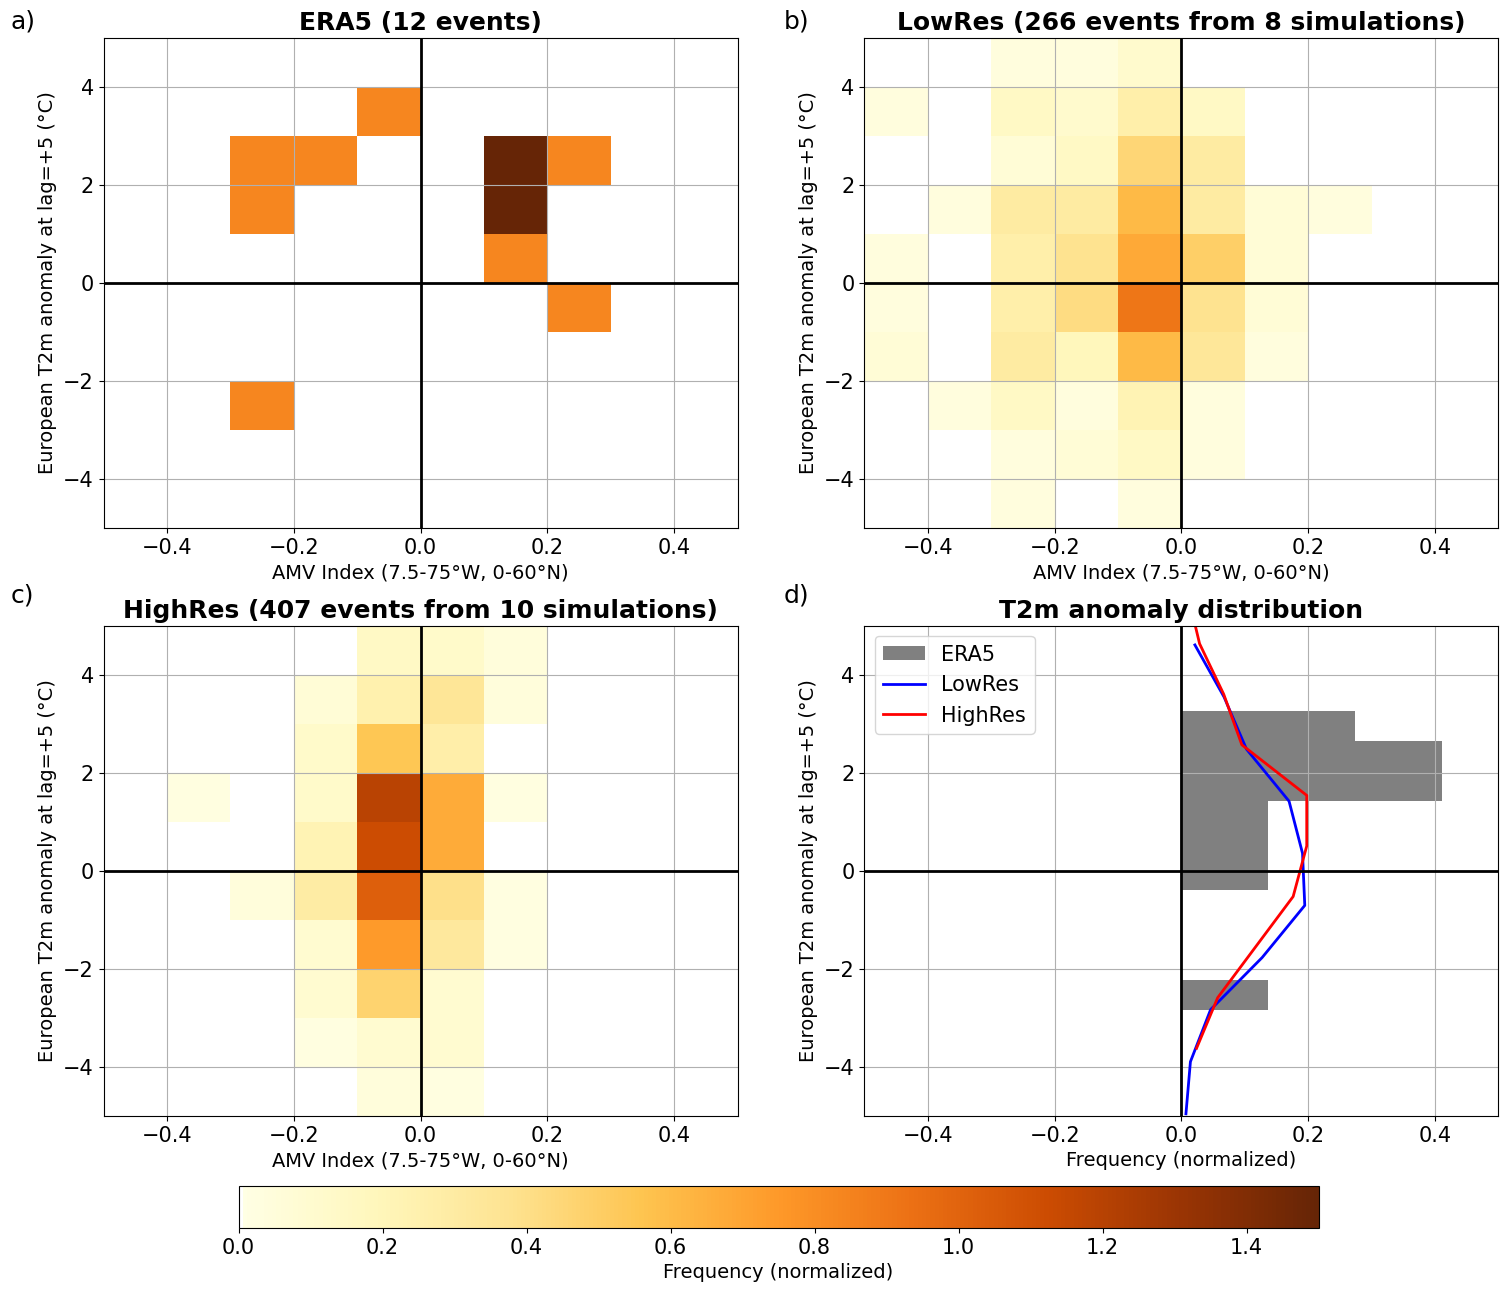

In [19]:
A = [HadISST_AMV_NAav_1979_2019, LR_AMV_c_sel_concat, HR_AMV_c_sel_concat]
B = [CMIP6_model_Euro_line_wtm[model_name[0]+variable[1]+resolution[0][0]+'Euro_line_wtm'][0].sel(lead_lag=5), LR_T2m_concat, HR_T2m_concat]

titles=['ERA5 (12 events)','LowRes (266 events from 8 simulations)', 'HighRes (407 events from 10 simulations)', 'T2m anomaly distribution']

#y_HadISST, binEdges_HadISST = np.histogram(HadISST_1979_2019_mon_JJA, bins=10,range=(-0.5, 0.5), density=True)
#bincenters = 0.5 * (binEdges_HadISST[1:] + binEdges_HadISST[:-1])
#y_LR, binEdges_LR = np.histogram(LR_AMV_mon_concat, bins=10,range=(-0.5, 0.5), density=True)
#y_HR, binEdges_HR = np.histogram(HR_AMV_mon_concat, bins=10,range=(-0.5, 0.5), density=True)
#print(bincenters)

fig = plt.figure(figsize=(18,14), rasterized=True)
axs=[]
for i in range(1,5):
    axs.append(fig.add_subplot(2,2,i))
    
for k in range(len(titles)):
    if k==0:
        hist1, xbins1, ybins1, im1 = axs[k].hist2d(A[k].sel(year = B[k].time.dt.year.astype(int)), B[k], bins=[10,10], range=[[-0.5, 0.5], [-5, 5]],cmap=YlOrBr_white_cm, density=True, vmin=0, vmax=1.5)
    elif k==1:
        for mod, res in low_res_type:
            hist2, xbins2, ybins2, im2 = axs[k].hist2d(A[k], B[k], bins=[10,10], range=[[-0.5, 0.5], [-5, 5]],cmap=YlOrBr_white_cm, density=True, vmin=0, vmax=1.5)
            #axb2 = axs[k].twinx()
            #axb2.plot(bincenters,(y_LR - y_HadISST), '--', c='black', lw=2, label='Difference (LR - HadISST)')
            #axb2.plot(bincenters,y_LR, '-', c='blue', lw=2, label='LR')
            #axb2.plot(bincenters,y_HadISST, '-', c='black', lw=2, label='HadISST')
            #axb2.set_ylim([-3,3])
            #axb2.set_ylabel('Frequency (normalized)', fontsize=14)
            #axb2.legend(fontsize=13, loc=4)
            
    elif k==2:
        for mod, res in high_res_type:
            hist3, xbins3, ybins3, im3 = axs[k].hist2d(A[k], B[k], bins=[10,10], range=[[-0.5, 0.5], [-5, 5]],cmap=YlOrBr_white_cm, density=True, vmin=0, vmax=1.5)
            #axc2 = axs[k].twinx()
            #axc2.plot(bincenters,(y_HR - y_HadISST), '--', c='black', lw=2, label='Difference (HR - HadISST)')
            #axc2.plot(bincenters,y_HR, '-', c='red', lw=2, label='HR')
            #axc2.plot(bincenters,y_HadISST, '-', c='black', lw=2, label='HadISST')
            #axc2.set_ylim([-3,3])
            #axc2.set_ylabel('Frequency (normalized)', fontsize=14)
            #axc2.legend(fontsize=13, loc=4)
    elif k==3: 
        #y0, binEdges0 = np.histogram(B[0], bins=100)
        axs[k].hist(B[0], bins=10, orientation='horizontal', density=True, color= 'grey', label='ERA5')

        y1, binEdges1 = np.histogram(B[1], bins=10, density=True)
        bincenters1 = 0.5 * (binEdges1[1:] + binEdges1[:-1])
        axs[k].plot(y1, bincenters1, '-', c='blue', label='LowRes', lw=2)

        y2, binEdges2 = np.histogram(B[2], bins=10, density=True)
        bincenters2 = 0.5 * (binEdges2[1:] + binEdges2[:-1])
        axs[k].plot(y2, bincenters2, '-', c='red', label='HighRes', lw=2)

    axs[k].set_title(titles[k], fontweight='bold')


for ax in axs:
    ax.set_ylim([-5,5])  
    ax.grid()
    ax.plot([-5,5], [0,0], 'k', lw=2)
    ax.plot([0,0], [-5,5], 'k', lw=2)
    ax.set_ylabel('European T2m anomaly at lag=+5 (°C)', fontsize=14)
    ax.set_xlim([-0.5, 0.5])                                                                                                                      


axs[0].set_xlabel('AMV Index (7.5-75°W, 0-60°N)', fontsize=14)
axs[1].set_xlabel('AMV Index (7.5-75°W, 0-60°N)', fontsize=14)
axs[2].set_xlabel('AMV Index (7.5-75°W, 0-60°N)', fontsize=14)
axs[3].set_xlabel('Frequency (normalized)', fontsize=14)

axs[3].legend()

cb_ax = fig.add_axes([0.2, 0.03, 0.6, 0.03])
cb = fig.colorbar(im1, cax=cb_ax, orientation='horizontal')
cb.ax.tick_params(labelsize=15)
cb.set_label(label='Frequency (normalized)', size=14)

plt.figtext(0.08,0.90,"a)", ha="center", va="top", fontsize=18)
plt.figtext(0.08,0.49,"c)", ha="center", va="top", fontsize=18)
plt.figtext(0.51,0.90,"b)", ha="center", va="top", fontsize=18)
plt.figtext(0.51,0.49,"d)", ha="center", va="top", fontsize=18)

plt.savefig('figs/fig5_AMV_var.pdf', bbox_inches='tight', dpi=200)